In [16]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.6.0
4.3.2
1.7.0
0.13.2


## STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어 추출

In [4]:
import os
from konlpy.tag import Okt

# 시놉시스 텍스트 데이터 경로 저장
data_dir = os.path.join(os.getenv("HOME"), "work/weat/data")
file_name = os.path.join(data_dir, "synopsis.txt")

okt = Okt()
tokenized = []

# 시놉시스에서 Okt 형태소 분석기를 통해 명사만 추출
# 약 15분정도 걸립니다.
with open(file_name, 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다.
        tokenized.append(res)


## STEP 2. 추출된 결과로 embedding model 만들기

In [6]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)



In [11]:
print('영화와 유사한 키워드')
print(model.wv.most_similar(positive=['영화']))
print(' ')

print('배우와 유사한 키워드')
print(model.wv.most_similar(positive=['배우']))
print(' ')

print('감동 유사한 키워드')
print(model.wv.most_similar(positive=['감동']))
print(' ')

영화와 유사한 키워드
[('작품', 0.876574695110321), ('다큐멘터리', 0.8486454486846924), ('드라마', 0.8229448795318604), ('영화로', 0.7946405410766602), ('형식', 0.7896430492401123), ('소재', 0.7811443209648132), ('코미디', 0.7806185483932495), ('주제', 0.770052433013916), ('멜로', 0.7683029770851135), ('인터뷰', 0.7633373141288757)]
 
배우와 유사한 키워드
[('여배우', 0.9335451126098633), ('시나리오', 0.9043847918510437), ('출연', 0.9042016267776489), ('데뷔', 0.8872586488723755), ('연극', 0.8782472610473633), ('작가', 0.87501460313797), ('연기', 0.8655537962913513), ('주연', 0.8614703416824341), ('소설', 0.8468145132064819), ('지망', 0.840387761592865)]
 
감동 유사한 키워드
[('선사', 0.9253177046775818), ('성장', 0.9194656014442444), ('스토리', 0.9194209575653076), ('판타지', 0.9087269902229309), ('주제', 0.9049552083015442), ('시적', 0.8968909382820129), ('드라마', 0.8923279047012329), ('감성', 0.888698399066925), ('청춘', 0.8860638737678528), ('예술', 0.884525716304779)]
 


## STEP 3. target, attribute 단어 셋 만들기

### target 단어 셋

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(data_dir + '/' + file_name, 'r') as fread:
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0]))
    return ' '.join(result)


In [61]:
art = read_token(art_txt)
gen = read_token(gen_txt)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)


synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.
(2, 41082)


In [89]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다.
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다.

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다.
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다.

target_art, target_gen = [], []

print('예술영화를 대표하는 단어들:')
for i in range(400):
    if vectorizer.get_feature_names_out()[w1[i][0]] in model.wv: # word2vec에 임베딩 되어 있는 명사인지 확인
        print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')
        target_art.append(vectorizer.get_feature_names_out()[w1[i][0]])

print('\n')

print('일반영화를 대표하는 단어들:')
for i in range(400):
    if vectorizer.get_feature_names_out()[w2[i][0]] in model.wv: # word2vec에 임베딩 되어 있는 명사인지 확인
        print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')
        target_gen.append(vectorizer.get_feature_names_out()[w2[i][0]])



예술영화를 대표하는 단어들:
귀요미, 인상파, 우승, 비인간, 비유, 여권, 체전, 난항, 마그니, 비서, 실체, 십만, 앨범, 상칼, 공효진, 스코프, 니시무라, 신주쿠, 성노동자, 여드름, 빌보드, 석면, 빅토르, 장청, 남건, 갈팡질팡, 언행, 바퀴, 온종일, 가이아나, 마등, 키타, 멜버른, 기묘, 제호, 불씨, 프란츠, 성대, 덴버, 결재, 용팔, 음력, 공채, 이심결, 경적, 간간이, 산샤, 무조건, 결말, 학생회, 존엄성, 억지, 의치, 젠스, 마술피리, 감언이설, 진국, 국립극장, 녹색혁명, 사설탐정, 철곤, 그래퍼, 애니매이션, 가족, 산골, 프랭키, 윤마담, 계약서, 마스, 삐라, 은혜, 거동, 어쩌다가, 만수, 베르날, 해방구, 해룡, 다르덴, 샤오요우, 해구, 이슨, 마돈나, 도넛, 레이싱, 무라카미, 제스처, 인도주의, 묶인, 새신랑, 공부, 성지, 도공, 보존, 헤이엑, 남산, 성격, 정거, 일상생활, 실업자, 얼핏, 단지, 독사, 스쿠버다이빙, 과도기, 엑스맨, 마르고, 콜로서스, 제니퍼, 모티브, 고수로, 박사, 표기, 대장장이, 진욱, 알론, 변호, 피카, 독립선언, 유례, 니키, 가스통, 수질, 모나코, 서기, 앤드루, 보일러, 사심, 숟가락, 이등병, 날다람쥐, 나다니엘, 일레인, 학예회, 주황색, 볼일, 조련사, 대북, 유명인사, 제스, 보임, 가자지구, 성장, 가게, 기웃, 미장센단편영화제, 스킨, 재칼, 앞차, 처절, 랭던, 파울로, 산동, 대가리, 공정, 천직, 보직, 귀신, 관광명소, 삼고, 종점, 인간성, 복제인간, 풀체, 퍼시픽, 그랜트, 앤지, 아구, 한시, 아랑, 식생활, 슴이, 사카, 에버렛, 기생, 배짱, 샤넬, 시빌, 장석, 박태호, 산나리, 디아즈, 우승자, 포욱, 남파, 어워즈, 각성, 감소, 링카, 주민등록, 전성, 항복, 대여, 의존, 석영, 스킨헤드, 왕가위, 귀순, 대악, 유리창, 은진, 리히터, 시뮬레이션, 고질, 은폐, 도시화, 의약, 자가, 존폐, 의무병, 사선, 미츠하, 청장, 일대기, 

### TF-IDF 기반의 대표 단어 셋 구축에서의 문제점
- 중복되는 단어가 다수 선정되어 각 부문을 대표하기 어렵다.
- 추출된 각 단어들을 살펴보면, 빈도 수를 기반으로 선택되었기에 예술과 일반 영화를 의미적으로 대표하기에 부족하다.

이러한 문제점을 개선하기 위해 clustering 방법을 이용하여 대표 단어 셋을 구축한다.

### Clustering을 통한 단어 셋 구축
- 각 target과 attrbute 별로 tf-idf를 계산한다.
- tf-idf를 기준으로 각각 상위 100개의 단어를 추출한다.
- 100개의 단어들을 kmeans 클러스터링 방식을 활용하여 word2vec embedding vector를 기반으로 K개의 클러스터를 만든다.
- 각 클러스터 중심과 가까운 상위 n개의 단어를 추출한다.
- 각 target과 attribute 별로 (K x n) 개의 단어로 단어 셋을 구축한다.

#### target 중복 제거

In [104]:
n = 100
w1_, w2_ = [], []
for i in range(1500):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(1500):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(1500):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [105]:
print(len(target_art))
print(len(target_gen))

100
100


#### Clustering

In [84]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# 클러스터 별 centroid와 가장 유사한 단어 topn 개 추출하는 함수
def top_words(cluster_words, centroid, topn=10):
    sims = [(w, cosine_similarity([v], [centroid])[0][0]) 
            for w, v in cluster_words]
    return sorted(sims, key=lambda x: -x[1])[:topn]
    

# tfidf_list: 선제적으로 tf-idf 선정한 단어 셋
# k: cluster 수
# w2v_model: word2vec model
# topn: cluster 당 대표 단어 수
def cluster_word_set(tfidf_list, k, w2v_model, topn, random_state):

    w2v = np.array([w2v_model.wv[word] for word in tfidf_list])
    
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    labels = kmeans.fit_predict(w2v)

    clusters = {c: [] for c in range(k)}
    # 단어를 클러스터에 할당
    for word, label, vec in zip(tfidf_list, labels, w2v):
        clusters[label].append((word, vec))
    
    
    word_candidates = {}
    # 클러스터 중심과 가장 가까운 (cosin 유사도) topn개의 단어 저장
    for c in range(k):
        centroid = kmeans.cluster_centers_[c]
        top = top_words(clusters[c], centroid, topn=topn)
        word_candidates[c] = [w for w, _ in top]
    
    
    cluster_word = []
    for c, words in word_candidates.items():
        print(f"Cluster {c}: {words}")
        cluster_word.extend(words)
    print(' ')
    
    return cluster_word

In [109]:
print('예술영화')
art_cluster_word = cluster_word_set(tfidf_list = target_art, k=10, w2v_model = model, topn=1, random_state=3)

print('일반영화')
gen_cluster_word = cluster_word_set(tfidf_list = target_gen, k=10, w2v_model = model, topn=1, random_state=3)

예술영화
Cluster 0: ['습도']
Cluster 1: ['우리']
Cluster 2: ['본성']
Cluster 3: ['유다']
Cluster 4: ['유럽']
Cluster 5: ['천재']
Cluster 6: ['가운데']
Cluster 7: ['점차']
Cluster 8: ['예술가']
Cluster 9: ['증명']
 
일반영화
Cluster 0: ['스탁']
Cluster 1: ['당신']
Cluster 2: ['오케스트라']
Cluster 3: ['세월']
Cluster 4: ['웃음']
Cluster 5: ['피트']
Cluster 6: ['소진']
Cluster 7: ['기념']
Cluster 8: ['철학']
Cluster 9: ['본격']
 


### attribute 단어 셋

In [69]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt',
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt',
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt',
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt',
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [70]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

vectorizer = TfidfVectorizer()
XX = vectorizer.fit_transform(genre)

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [71]:
XX.shape

(21, 42191)

In [112]:
m = [XX[i].tocoo() for i in range(XX.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
    
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 400):
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv: # word2vec에 임베딩 되어 있는 명사인지 확인
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            #print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 
가족: 
공연: 
공포(호러): 
기타: 
다큐멘터리: 
드라마: 
멜로로맨스: 
뮤지컬: 
미스터리: 
범죄: 
사극: 
서부극(웨스턴): 
성인물(에로): 
스릴러: 
애니메이션: 
액션: 
어드벤처: 
전쟁: 
코미디: 
판타지: 


In [113]:
attr_word_list = []

for i in range(len(genre_name)):
    print(genre_name[i])
    attr_word = cluster_word_set(tfidf_list = attributes[i], k=10, w2v_model = model, topn=1, random_state=3)
    attr_word_list.append(attr_word)


SF
Cluster 0: ['소녀']
Cluster 1: ['플루토']
Cluster 2: ['음모']
Cluster 3: ['과학']
Cluster 4: ['외계']
Cluster 5: ['영화제']
Cluster 6: ['의문']
Cluster 7: ['남자']
Cluster 8: ['마주']
Cluster 9: ['역사']
 
가족
Cluster 0: ['마주']
Cluster 1: ['휴고']
Cluster 2: ['감정']
Cluster 3: ['부산']
Cluster 4: ['작품']
Cluster 5: ['강아지']
Cluster 6: ['최고']
Cluster 7: ['다른']
Cluster 8: ['방법']
Cluster 9: ['오빠']
 
공연
Cluster 0: ['납치']
Cluster 1: ['이내']
Cluster 2: ['수잔나']
Cluster 3: ['콘서트']
Cluster 4: ['자매']
Cluster 5: ['역사']
Cluster 6: ['여자']
Cluster 7: ['계획']
Cluster 8: ['감동']
Cluster 9: ['애인']
 
공포(호러)
Cluster 0: ['오두막']
Cluster 1: ['필름']
Cluster 2: ['실체']
Cluster 3: ['발견']
Cluster 4: ['서로']
Cluster 5: ['두려움']
Cluster 6: ['용의자']
Cluster 7: ['느낌']
Cluster 8: ['언니']
Cluster 9: ['제시카']
 
기타
Cluster 0: ['소통']
Cluster 1: ['아야카']
Cluster 2: ['바람']
Cluster 3: ['상영']
Cluster 4: ['살인']
Cluster 5: ['다른']
Cluster 6: ['부모']
Cluster 7: ['애인']
Cluster 8: ['퍼포먼스']
Cluster 9: ['부문']
 
다큐멘터리
Cluster 0: ['위해']
Cluster 1: ['칠레']
Cluster 2: ['구조']

## STEP 4. WEAT score 계산과 시각화

In [118]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):

    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))

    return  (mean_X-mean_Y)/std_dev


In [119]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [120]:
X = np.array([model.wv[word] for word in art_cluster_word])
Y = np.array([model.wv[word] for word in gen_cluster_word])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attr_word_list[i]])
        B = np.array([model.wv[word] for word in attr_word_list[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [137]:
X = np.array([model.wv[word] for word in art_cluster_word])
Y = np.array([model.wv[word] for word in gen_cluster_word])

for i in range(len(genre_name)):
    for j in range(len(genre_name)):
        if i != j:
            A = np.array([model.wv[word] for word in attr_word_list[i]])
            B = np.array([model.wv[word] for word in attr_word_list[j]])
            matrix[i][j] = weat_score(X, Y, A, B)

In [131]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 0.8 or matrix[i][j] < -0.8:
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 드라마 0.87853706
가족 드라마 0.91591895
공연 범죄 -0.8172563
공포(호러) 드라마 0.9007666
공포(호러) 코미디 1.05031
다큐멘터리 드라마 0.90571624
드라마 어드벤처 -0.9378437
범죄 코미디 1.1319684
사극 코미디 0.89819294
성인물(에로) 코미디 0.8370452
스릴러 코미디 0.8048933


In [126]:
!sudo apt-get update -qq
!sudo apt-get install -qq fonts-nanum

debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package fonts-nanum.
(Reading database ... 68201 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.15.0-1.1ubuntu2) ...


In [128]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

<Axes: >

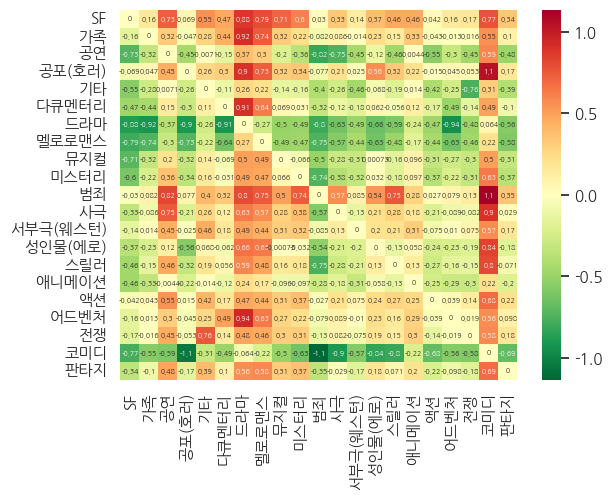

In [138]:
import numpy as np;
import seaborn as sns;

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, annot_kws={"size": 5},  cmap='RdYlGn_r')
ax

In [150]:
avg_abs_weat_score = np.sum(abs(np.array(matrix)), axis=1)/(len(genre_name)-1)
min_genre_index = avg_abs_weat_score.argmin()

print("절대 평균 WEAT score 최소 장르: ", genre_name[min_genre_index], avg_abs_weat_score[min_genre_index])

절대 평균 WEAT score 최소 장르:  애니메이션 0.1981256996281445


#### WEAT score 분석

- 드라마, 멜로로맨스, 코미디의 장르에 경우, 대체로 음의 값을 가지므로 대부분의 장르들 보다 일반영화에 가깝다고 볼 수 있다.
- SF, 가족, 공포(호러)의 장르에 경우, 대체로 양의 값을 갖거나 0에 가까움으로 대부분의 장르들 보다 예술영화에 가깝다고 할 수 있다.
- 애니메이션은 절대 평균 WEAT score가 0.198 로 가장 낮기에, 다른 장르들 보다 예술영화나 일반영화 어디에도 편향되어 있지 않다고 판단할 수 있다.
- 가장 높은 WEAT score는 공포(호러) 장르와 코미디 간의 score로 1.1이였으며, 공포(호러)는 코미디 보다 예술 영화에 가까우며, 코미디는 공포(호러)보다 일반 영화에 가깝다고 할 수 있다.